#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Импорт-библиотек,-создание-констант,-установка-настроек" data-toc-modified-id="Импорт-библиотек,-создание-констант,-установка-настроек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт библиотек, создание констант, установка настроек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-временного-ряда" data-toc-modified-id="Анализ-временного-ряда-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ временного ряда</a></span></li><li><span><a href="#Обучение-моделей,-подбор-параметров" data-toc-modified-id="Обучение-моделей,-подбор-параметров-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение моделей, подбор параметров</a></span></li><li><span><a href="#Анализ-лучшей-модели" data-toc-modified-id="Анализ-лучшей-модели-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ лучшей модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Описание проекта

Компания агригатор собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, требуется спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Этапы работы:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке.

**Данные для исследования:**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорт библиотек, создание констант, установка настроек

In [1]:
# Загружаем основные библиотеки
import time
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Импорт модулей для анализа временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Импортируем библиотеку optuna, для гиперпараметров, (если она не установлена, устанавливаем)
try:
    import optuna
    from optuna.samplers import TPESampler
except:
    !pip install optuna -q
    import optuna
    from optuna.samplers import TPESampler

In [4]:
# Импорт модулей для создания пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector as selector

# Импорт модуля для разбивки данных на тренировочную и тестовую выборки и кроссвалидации
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit

# Импорт модулей для кодирования и масштабирования
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler, 
                                   FunctionTransformer)

# Импорт моделей машинного обучения
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

# Импорт модулей для создания пайплайна
from sklearn.compose import (ColumnTransformer,
                             make_column_selector)

# Импорт модуля для работы с пропусками
from sklearn.impute import SimpleImputer, KNNImputer

# Импорт метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
# Импортируем модель градиентного бустинга LightGBM
import lightgbm as lgb

In [6]:
# Убираем необязательные предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настраиваем отображение всех строк таблицы
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Задаём стандартне параметры для графиков
plt.rcParams['figure.figsize'] = (13, 5)
plt.rcParams.update({'font.size':'12'})

# Скрываем журнал с триалами
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [7]:
# Создание констант
RANDOM_STATE = 38

## Загрузка данных

In [8]:
# Загружаем данные
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
    print(f'Размер датафрейма: {data.shape}')
except:
    print('Данные не были загружены.')

Размер датафрейма: (26496, 2)


In [9]:
# Просмотр общей информации
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [10]:
# Смотрим датафрейм
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


**Итоги загрузки данных:**

Данные были загружены. Данные соответствуют описанию.

## Подготовка данных

In [11]:
# Устанавливаем столбец с датой в качестве индекса
df = data.set_index('datetime')

# Ресемплируем по одному часу
df = df.resample('1H').sum()

# Смотрим датафрейм
print(f'Размер ресемплированного датафрейма: {df.shape}')
df.head()

Размер ресемплированного датафрейма: (4416, 1)


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проверим, что все даты идут по порядку.

In [12]:
print('Даты идут по порядку:', df.index.is_monotonic)

Даты идут по порядку: True


Посмотрим диапазон дат.

In [13]:
print('Начало временного ряда:', df.index.min())
print('Конец временного ряда:', df.index.max())

Начало временного ряда: 2018-03-01 00:00:00
Конец временного ряда: 2018-08-31 23:00:00


Нам предоставлены даты с марта по август включительно.

**Итоги подготовки данных:**

Данные были ресемплированы по 1 часу. Даты идут по порядку, с марта по август включительно.

## Анализ временного ряда

**Посмотрим график временного ряда**

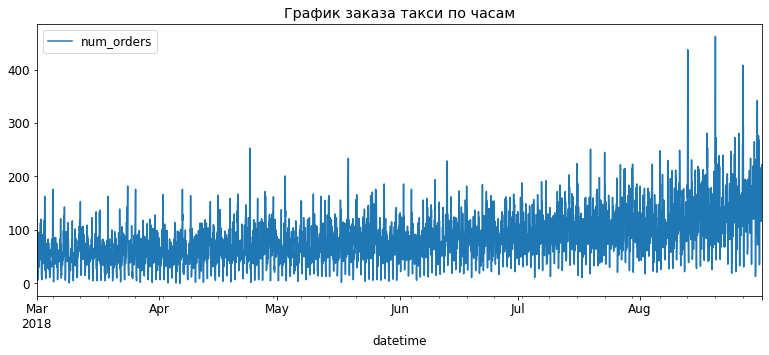

In [14]:
df.plot()
plt.title('График заказа такси по часам')
plt.show()

**Ресемплируем временной ряд по неделям и построим график, что бы определеть общую тенденцию**

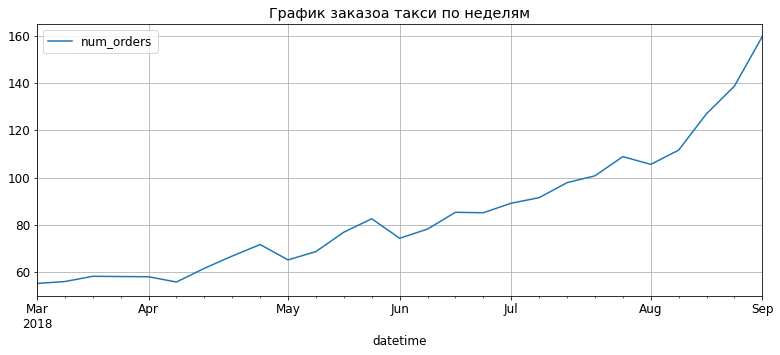

In [15]:
df.resample('1W').mean().plot()
plt.title('График заказоа такси по неделям')
plt.grid()
plt.show()

Видна явная тенденция на увеличение количества заказов. Скорее всего это связано с сезонностью, но возможно дело в том, что сервис активно развивается и привлекает новых клиентов.

**Посмотрим пару недель августа, что бы определить недельные тренды**

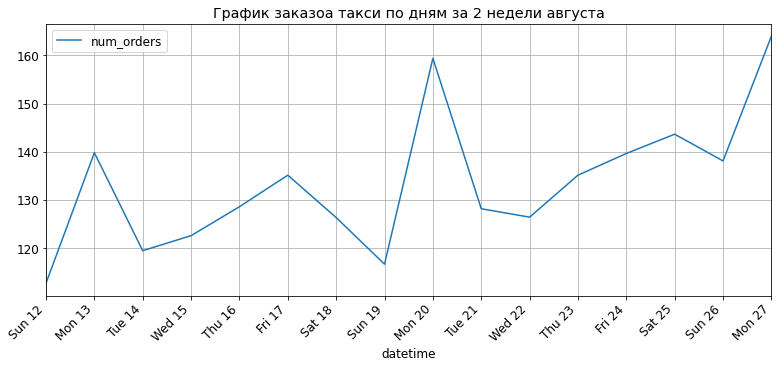

In [16]:
df_daily = df.resample('1D').mean()
df_last_month = df_daily['2018-08-12':'2018-08-27']

ax = df_last_month.plot()
ax.set_xticks(df_last_month.index)
ax.set_xticklabels(df_last_month.index.strftime('%a %d'), rotation=45, ha='right')

plt.title('График заказоа такси по дням за 2 недели августа')
plt.grid()
plt.show()

del df_daily
del df_last_month

Больше всего заказов по понедельникам. Меньше всего по вторникам и воскресеньям.

**Посмотрим несколько дней августа, что бы определить суточные тренды**

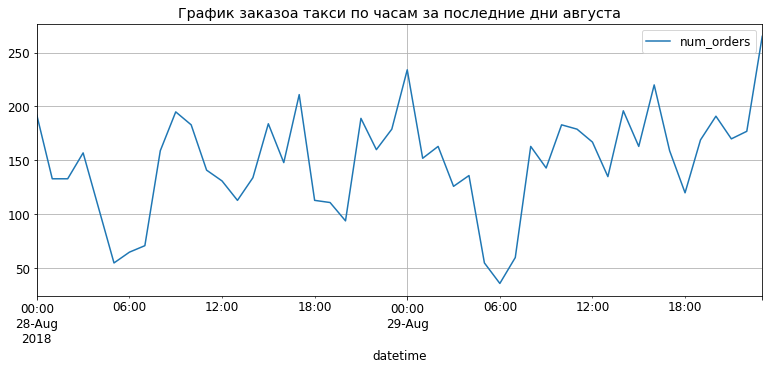

In [17]:
df['2018-08-28':'2018-08-29'].plot()
plt.title('График заказоа такси по часам за последние дни августа')
plt.grid()
plt.show()

- В районе 6:00, 13:00 и 18:00 наблюдаются спады количества заказов.
- В районе 0:00, 10:00 и 16:00 наблюдаются пики количества заказов.

**Разложим временной ряд на тренд и сезонную компоненту, посмотрим общий тренд на графике**

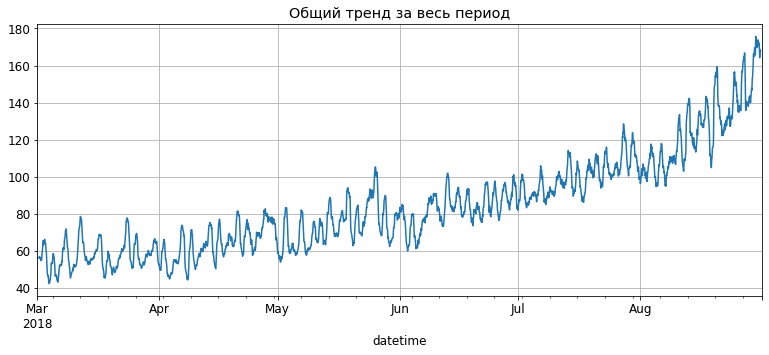

In [18]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot()
plt.title('Общий тренд за весь период')
plt.grid()
plt.show()

**Разложим временной ряд за август на тренд и сезонную компоненту**

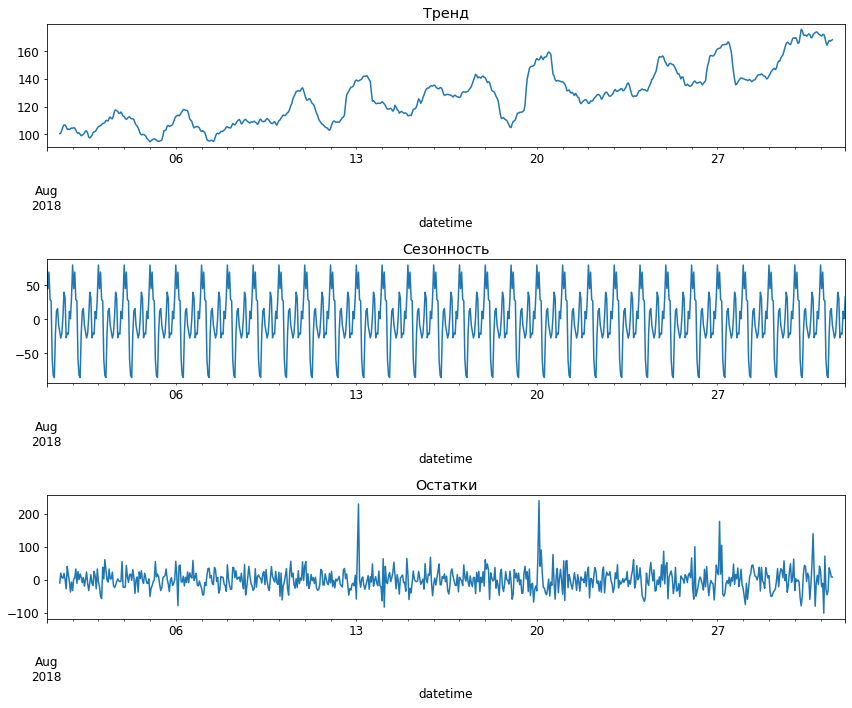

In [19]:
decomposed = seasonal_decompose(df['2018-08':]) 

plt.figure(figsize=(12, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.tight_layout()

- Тренд связан с колебанием заказов в зависимости от дня недели, и общей тенденцией к увеличению количества заказов.
- Сезонность связана со временем суток.
- Остатки необъяснимы.

**Посмотрим среднее и скользящее стандартное отклонение**

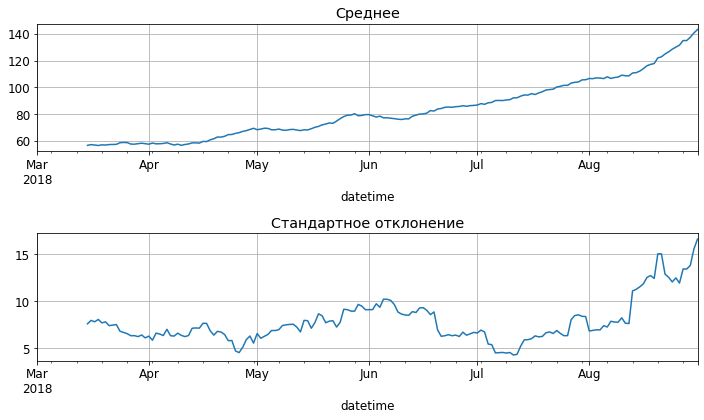

In [20]:
df_daily = df_daily = df.resample('1D').mean()
df_daily['mean'] = df_daily['num_orders'].rolling(15).mean()
df_daily['std'] = df_daily['num_orders'].rolling(15).std()

plt.figure(figsize=(10, 6))
plt.subplot(211)

df_daily['mean'].plot(ax=plt.gca())
plt.title('Среднее')
plt.grid()
plt.subplot(212)

df_daily['std'].plot(ax=plt.gca())
plt.title('Стандартное отклонение')
plt.grid()
plt.tight_layout()

Ряд не стационарный, т.к. среднее и скользящее стандартное отклонения значительно меняются.

**Вывод:**

- Проанализорован временной ряд с количеством заказов такси с марта по август (включительно).
- Временно ряд не стационарный.
- Видна общая тенденция к увеличению количества заказов.
- Наблюдается сезонность по дням недели и по времени суток.

## Обучение моделей, подбор параметров

**Разделяем датасет на тренировочную и тестовую выборки**

In [21]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

print(f'Тренировочная выборка с {train.index.min()}, по {train.index.max()}')
print(f'Тестовая выборка с {test.index.min()}, по {test.index.max()}')

Тренировочная выборка с 2018-03-01 00:00:00, по 2018-08-13 13:00:00
Тестовая выборка с 2018-08-13 14:00:00, по 2018-08-31 23:00:00


**Предскажим средним**

In [22]:
print(f"Среднее количество заказов такси в час на тестовой выборке: {test['num_orders'].mean():.2f}")

pred_median = [train['num_orders'].median()] * test.shape[0]
rmse = mean_squared_error(test['num_orders'], pred_median, squared=False)
print(f"RMSE при предсказании средним: {rmse:.2f}")

Среднее количество заказов такси в час на тестовой выборке: 139.56
RMSE при предсказании средним: 87.15


**Предскажем предыдущим значением ряда**

In [23]:
print(f"Среднее количество заказов такси в час на тестовой выборке: {test['num_orders'].mean():.2f}")

pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]
rmse = mean_squared_error(test['num_orders'], pred_previous, squared=False)
print(f"RMSE при предсказании предыдущим значением ряда: {rmse:.2f}")

Среднее количество заказов такси в час на тестовой выборке: 139.56
RMSE при предсказании предыдущим значением ряда: 58.86


**Удалим лишние переменные**

In [24]:
del train, test

**Добавим в датасет новые признаки**

In [25]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

df_for_models = make_features(df, 48, 48)
df_for_models.sample()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-15 09:00:00,74,6,15,4,69.0,27.0,26.0,79.0,103.0,89.0,120.0,89.0,124.0,119.0,79.0,99.0,109.0,43.0,42.0,124.0,107.0,78.0,55.0,66.0,101.0,63.0,94.0,84.0,66.0,31.0,19.0,36.0,117.0,115.0,148.0,58.0,162.0,69.0,70.0,104.0,96.0,105.0,57.0,72.0,118.0,83.0,80.0,84.0,87.0,66.0,76.0,112.0,83.75


**Разделяем датасет на тренировочную и тестовую выборки, удаляем пропуски в новых признаках**

In [26]:
train, test = train_test_split(df_for_models, shuffle=False, test_size=0.1)

train = train.dropna() 

X_train = train.drop(columns='num_orders')
y_train = train['num_orders']

X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (3926, 52)
y_train:  (3926,)
X_test:  (442, 52)
y_test:  (442,)


**Тестируем модель LGBMRegressor**

In [27]:
# Функция для оптимизации гиперпараметров
def objective(trial):
    # Используем TimeSeriesSplit для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=5)    

    # Задаем диапазоны гиперпараметров для подбора lgb
    param = {
        'n_estimators': 50,
        'subsample': trial.suggest_float('subsample', 0.6, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 10, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 15),
        'random_state': RANDOM_STATE
    }
    
    model = lgb.LGBMRegressor(**param)
    
    # Оцениваем модель на кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    
    # Возвращаем средний отрицательный RMSE (для минимизации)
    return -score.mean()

In [28]:
# Создаем объект для оптимизации с помощью Optuna
sampler = TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Выводим наилучшие параметры
print(f"Best parameters found by Optuna: {study.best_params}")
print()

# Извлекаем лучшую метрику на кроссвалидации
best_rmse = study.best_value
print(f"RMSE лучшей модели LGBMRegressor на кроссвалидации: {best_rmse:.2f}")

# Создаем модель с наилучшими параметрами и сохраняем её в переменную
model_lgb = lgb.LGBMRegressor(**study.best_params, random_state=RANDOM_STATE)

  0%|          | 0/10 [00:00<?, ?it/s]

Best parameters found by Optuna: {'subsample': 0.7652716050445982, 'learning_rate': 0.23229734323231227, 'num_leaves': 10, 'min_child_samples': 7}

RMSE лучшей модели LGBMRegressor на кроссвалидации: 24.45


**Тестируем модель Ridge**

In [29]:
# Функция для оптимизации гиперпараметров
def objective(trial):
    # Используем TimeSeriesSplit для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=5)   
    
    # Задаем диапазоны гиперпараметров для подбора
    param = {
        'alpha': trial.suggest_float('alpha', 0.5, 5.0),
        'solver': trial.suggest_categorical('solver', ['auto', 'lsqr']),
        'random_state': RANDOM_STATE
    }
    
    model = Ridge(**param)
    
    # Оцениваем модель на кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    
    # Возвращаем средний отрицательный RMSE (для минимизации)
    return -score.mean()

In [30]:
# Создаем объект для оптимизации с помощью Optuna
sampler = TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Выводим наилучшие параметры
print(f"Best parameters found by Optuna: {study.best_params}")
print()

# Извлекаем лучшую метрику на кроссвалидации
best_rmse = study.best_value
print(f"RMSE лучшей модели Ridge на кроссвалидации: {best_rmse:.2f}")

# Создаем модель Ridge с наилучшими параметрами и сохраняем её в переменную
model_ridge = Ridge(**study.best_params, random_state=RANDOM_STATE)

  0%|          | 0/10 [00:00<?, ?it/s]

Best parameters found by Optuna: {'alpha': 1.40057079286957, 'solver': 'auto'}

RMSE лучшей модели Ridge на кроссвалидации: 24.60


**Итоги тестирования моделей**

Было протестировано 2 модели:
- LGBMRegressor
- Ridge

Лучший результат на кроссвалидации (TimeSeriesSplit) показала модель LGBMRegressor.

## Анализ лучшей модели

**Проверяем модель на тестовой выборке**

In [31]:
model_lgb.fit(X_train, y_train)
preds = model_lgb.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE модели LGBMRegressor на тестовой выборке: {rmse:.2f}")

RMSE модели LGBMRegressor на тестовой выборке: 40.67


**Визуализируем результаты работы модели на графике**

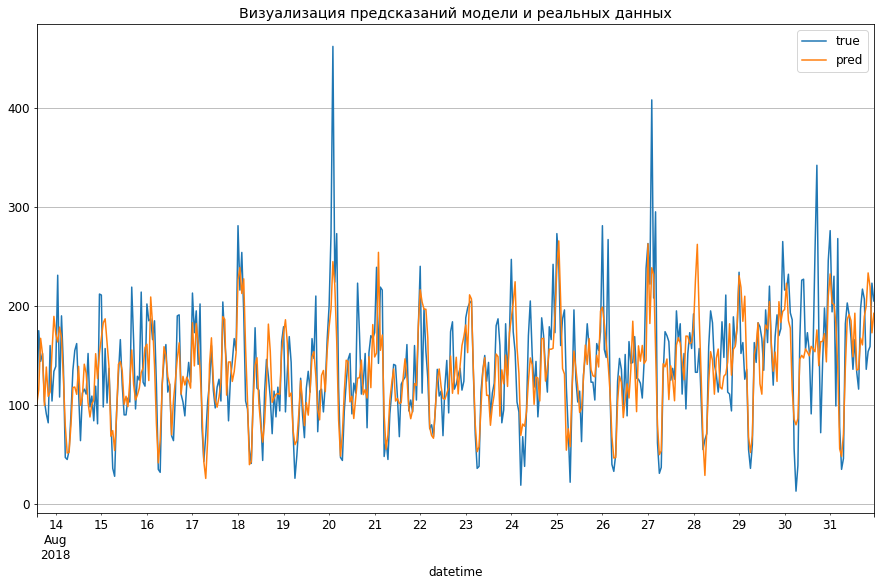

In [32]:
df_show = pd.DataFrame({'true': y_test, 'pred': preds})
plt.figure(figsize=(15, 9))
plt.title('Визуализация предсказаний модели и реальных данных')
df_show.plot(ax=plt.gca())
plt.grid()
plt.show()

Из данного графика можно сделать вывод, что модель работает достаточно точно. 

Модель дала заниженные предсказания в пиковые часы 20-го и 27-го августа (поскольку в конце августа пассажиро-поток увеличился, относительно тех данных, на которых обучалась модель). 

Кроме того, модель не смогла предсказать пиковые часы, 30-го - 31-го августа, которые не были связаны с сезонными колебаниями (по времени суток). Скорее всего это связано с приездом борльшого количества пассажиров перед 1-м сентября. Но для более точного обучения модели нужны данные за прошлый год.

## Вывод

В ходе исследования был проанализорован временной ряд с количеством заказов такси с марта по август (включительно).

О данном временом ряде можно сказать следующее:
- Видна общая тенденция к увеличению количества заказов.
- Наблюдается сезонность по дням недели и по времени суток.

Для прогнозирования количества заказов на следующий час было протестировано две модели: LGBMRegressor и Ridge.

Лучший результат показала модель LGBMRegressor, RMSE модели LGBMRegressor на тестовой выборке: 40.67

Данный результат удовлетворяет требованию заказчика: "Значение метрики RMSE на тестовой выборке должно быть не больше 48."